In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

This is an algorithm for the simplified version of crystal plasticity. This version does not include texture evoution and only touches upon a stress update algorithm.

# Define constants:

In [2]:
m = 0.02  # Strain-rate constant
n = 0.1 # Power-law constant: hardening exponent

e_dot_0 = 0.001  # ??

t_0 = 200  # [MPa] Critical resolved shear stress

h_0 = 250  # [MPa] Initial hardness after yeilding

sigma_bar = t_0  # [MPa] Initial hardening value (yield strength)

e_bar_p = 0 # Initial hardness-related parameter (equivalent to accumulated slip in crystal plasticity)

In [3]:
# Elastic tensor:

L = np.zeros((6, 6))

for i in [0, 1, 2]:
    L[i, i] = 1.0372e+5

for i in [3, 4, 5]:
    L[i, i] = 25316

for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        if i != j:
            L[i, j] = 51084


print("Elastic tensor:\n\n", L)

Elastic tensor:

 [[103720.  51084.  51084.      0.      0.      0.]
 [ 51084. 103720.  51084.      0.      0.      0.]
 [ 51084.  51084. 103720.      0.      0.      0.]
 [     0.      0.      0.  25316.      0.      0.]
 [     0.      0.      0.      0.  25316.      0.]
 [     0.      0.      0.      0.      0.  25316.]]


Strain and stress (-rate, too) tensor are written in the Voigt notation:

$\tilde{\sigma}=\left(\sigma_{x x}, \sigma_{y y}, \sigma_{z z}, \sigma_{y z}, \sigma_{x z}, \sigma_{x y}\right) \equiv\left(\sigma_{1}, \sigma_{2}, \sigma_{3}, \sigma_{4}, \sigma_{5}, \sigma_{6}\right)$

In [4]:
# Time step:

delta_t = 1

print("Time-step:\n\n", delta_t)

# Input strain-rate tensor:

D = np.asarray([1.0, -0.5, -0.5, 0.0, 0.0, 0.0])*1e-05

print("\n\nInput strain-rate tensor:\n\n", D)

T = int(0.1/D[0]/delta_t)

print("\n\nThe number of time-steps:\n\n", T)

Time-step:

 1


Input strain-rate tensor:

 [ 1.e-05 -5.e-06 -5.e-06  0.e+00  0.e+00  0.e+00]


The number of time-steps:

 10000


In [5]:
# Stress and strain tensors:

stress = np.zeros((6,))
print("Initial stress-tensor:\n\n", stress)

strain = np.zeros((6,))
print(" \n\nInitial strain-tensor:\n\n", strain)

Initial stress-tensor:

 [0. 0. 0. 0. 0. 0.]
 

Initial strain-tensor:

 [0. 0. 0. 0. 0. 0.]


# Helper functions

In [6]:
def dev_stress(stress):
    """
    Calculate deviatoric stress component, 
    stress [6x1]
    dev_stress [6x1]
    """
    trace_s = stress[0] + stress[1] + stress[2]
    dev_stress = stress - trace_s*np.asarray([1, 1, 1, 0, 0, 0])/3

    return dev_stress

In [7]:
def sigma_vm(stress):
    """
    Von Mises equivalent stress, ver 1
    """
    s = dev_stress(stress)

    stress_vm = 0

    for i in range(6):
        if i > 2:
            stress_vm += 2*s[i]*s[i]
        else:
            stress_vm += s[i]*s[i]

    return np.sqrt(3*stress_vm/2)

$\tilde{\sigma}=\left(\sigma_{x x}, \sigma_{y y}, \sigma_{z z}, \sigma_{y z}, \sigma_{x z}, \sigma_{x y}\right) \equiv\left(\sigma_{0}, \sigma_{1}, \sigma_{2}, \sigma_{3}, \sigma_{4}, \sigma_{5}\right)$

In [8]:
def sigma_vm2(stress):
    """
    Von Mises equivalent stress, ver 2
    """

    a = (stress[0] - stress[1])**2 + \
        (stress[1] - stress[2])**2 + \
        (stress[2] - stress[0])**2

    b = 6 *\
        (stress[3]**2 + stress[4]**2 + stress[5]**2)

    return np.sqrt(0.5*(a + b))

In [9]:
def calculate_e_bar_dot_p(e_dot_0, stress, sigma_bar, m):
    """
    Calculate e_bar_dot_p
    """

    e_bar_dot_p = e_dot_0 * (sigma_vm(stress)/sigma_bar)**(1/m)
    
    return e_bar_dot_p

In [10]:
def tc_4d2(L, D):
    """
    Double-dot product, Voigt notation
    L - [6x6]
    D - [6x1]
    L:D - [6x1]
    """
    
    return np.matmul(L,D)

In [11]:
def calculate_Dp(e_bar_dot_p, stress):
    """
    Dp -- [6x1]
    """
    
    Dp = e_bar_dot_p * (3/2) * dev_stress(stress)/sigma_vm(stress)
    
#     print('Dp:\t', Dp)
    
    return Dp

In [12]:
def stress_update(L, D, Dp, sigma_t, delta_t):
    """
    Calculate delta sigma 
    Update the stress [6x1]
    """
    
    d_sigma = tc_4d2(L, D) - tc_4d2(L, Dp)

    return sigma_t + d_sigma*delta_t

In [13]:
def hardness_update(h_0, t_0, n, e_bar_dot_p, e_bar_p, sigma_bar, delta_t):
    """
    Updating the hardness-related variables:sigma_bar and the variable e_bar_p
    """
   
    # Update epsilon bar p:
    delta_e_bar_p = e_bar_dot_p*delta_t
    e_bar_p = e_bar_p + delta_e_bar_p

    # Update sigma bar:
    delta_sigma_bar = h_0 * \
        ((h_0 * e_bar_p)/(t_0 * n) + 1)**(n-1) * \
        delta_e_bar_p
    
    sigma_bar_new = sigma_bar + delta_sigma_bar

    return e_bar_p, sigma_bar_new

# Stress integration: a stress-update algorithm

1. Find  $\dot{\bar{\varepsilon}}^{p}$: 


$\dot{\bar{\varepsilon}}^{p}=\dot{\varepsilon_{0}} \cdot\left(\frac{\sigma_{e q}\left(\sigma_{t}\right)}{\bar{\sigma}}\right)^{1 / m}$


2. Find $D^{p}$:

$D^{p}=\dot{\bar{\varepsilon}}^{p} \frac{3}{2} \cdot \frac{\sigma_{t}^{dev}}{\sigma_{e q}\left(\sigma_{t}\right)}$

3. Calculate $\dot{\sigma}$

$\dot{\sigma}=L: D-L: D^{p}$

4. Update hardness:

$\Delta \bar{\sigma}=h_{0}\left(\frac{h_{0} \bar{\varepsilon}^{p}}{\tau_{0} n}+1\right)^{n-1} \cdot\left(\Delta \bar{\varepsilon}^{p}\right)$

$\bar{\sigma}_{t+1}=\bar{\sigma}_{t}+\Delta \bar{\sigma}$


In [14]:
%%time
%%capture
stress = np.zeros((6,))
print("Initial stress-tensor:\n\n", stress)

strain = np.zeros((6,))
print(" \n\nInitial strain-tensor:\n\n", strain)

# Initialize history variables 

stress_history = {}
strain_history = {}

for i in ['11', '22', '33', '23', '13', '12']:
    stress_history[i] = [0]
    strain_history[i] = [0]    
    
sigma_bar_history = [sigma_bar]
    
for timestep in range(T):
    print('\n\n\n\n')
    e_bar_dot_p = calculate_e_bar_dot_p(e_dot_0, stress, sigma_bar, m)
    
    if timestep == 0:
        Dp = np.zeros((6,))
    else:
        Dp = calculate_Dp(e_bar_dot_p, stress)
    
    stress = stress_update(L, D, Dp, stress, delta_t)
    
    e_bar_p, sigma_bar = hardness_update(h_0, t_0, n, e_bar_dot_p, e_bar_p, sigma_bar, delta_t)
    
    # Save history variables:
    
    sigma_bar_history.append(sigma_bar)
    
    idx = 0
    for i in ['11', '22', '33', '23', '13', '12']:
        stress_history[i].append(stress[idx])
        strain_history[i].append(D[idx]*(timestep+1))
        idx+=1
#             

CPU times: user 685 ms, sys: 37.8 ms, total: 723 ms
Wall time: 699 ms


# Plot results

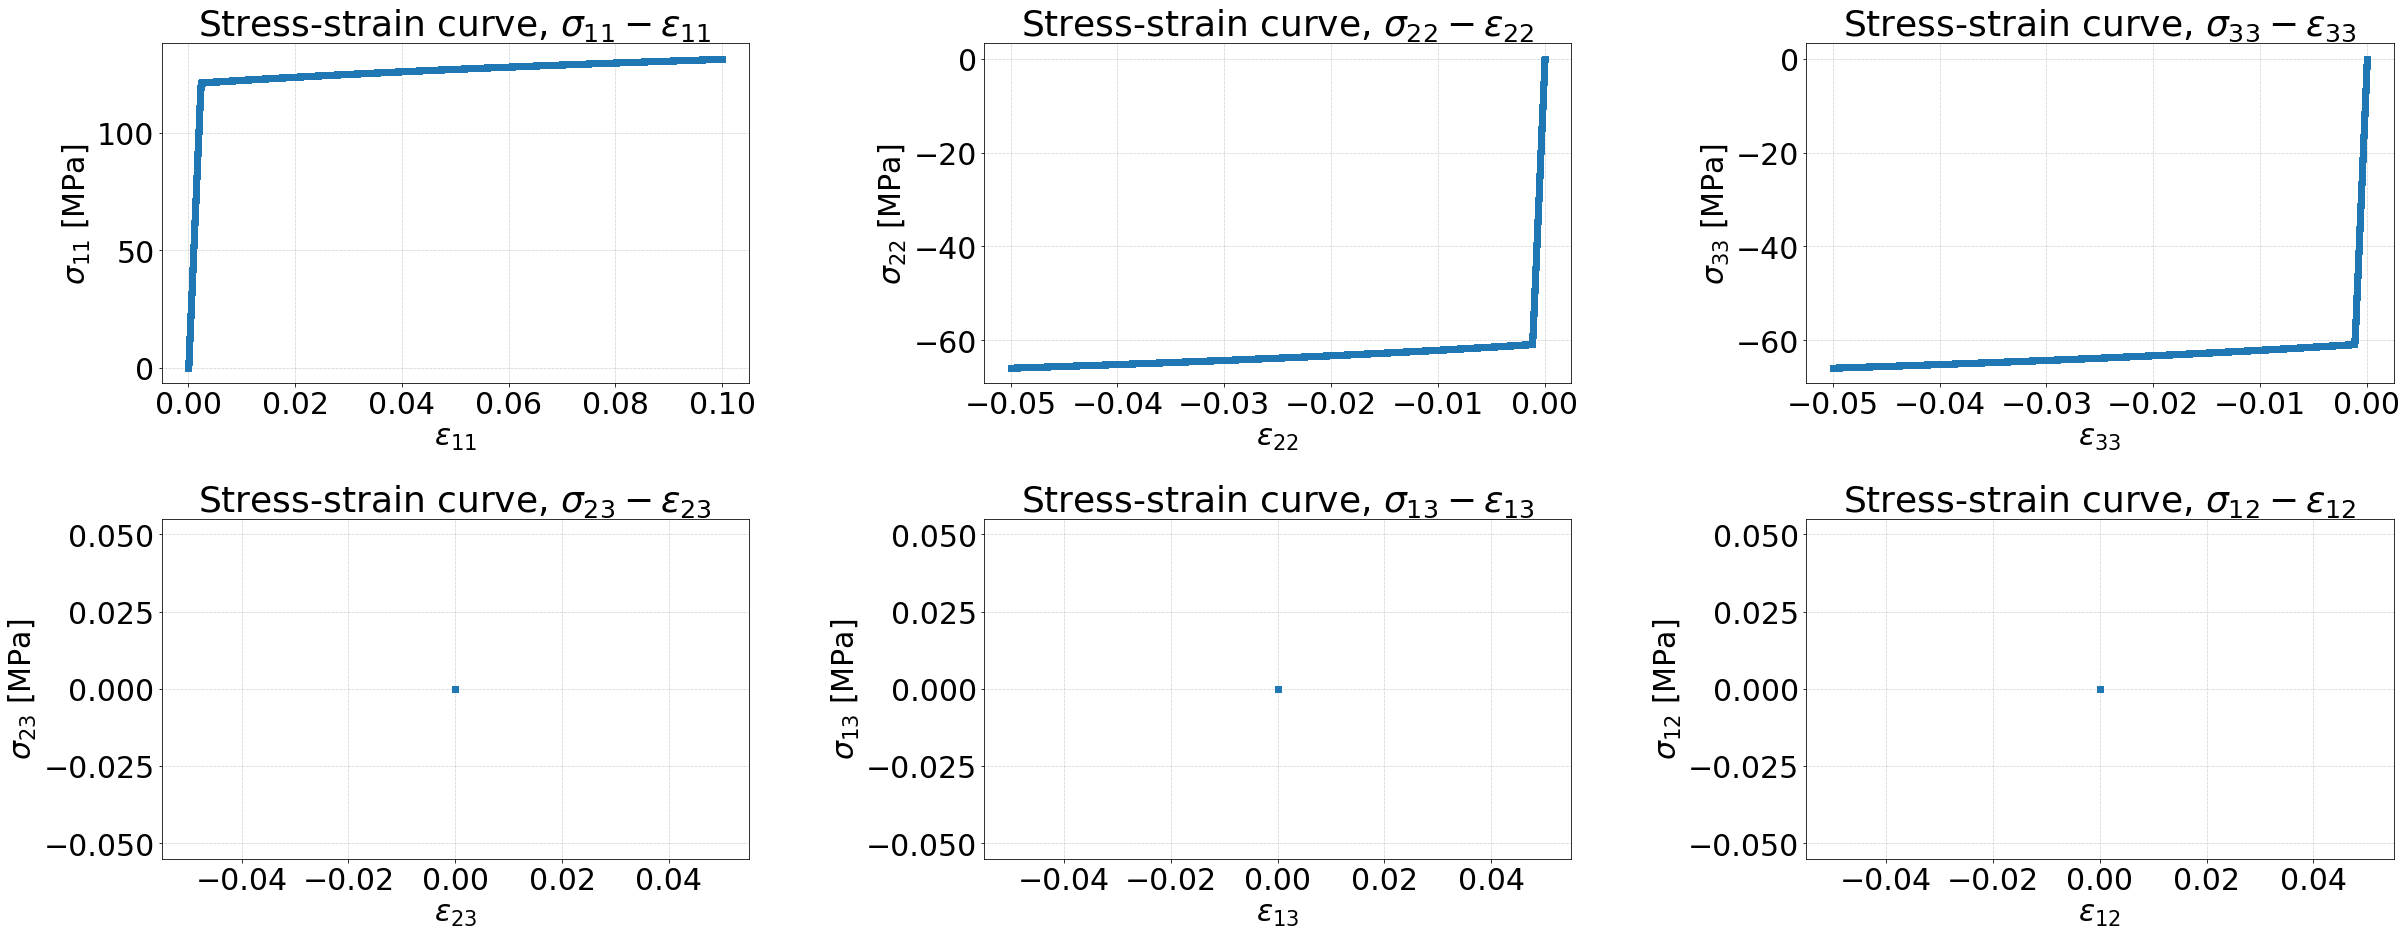

In [15]:
plt.rcParams.update({'font.size': 30})

plt.figure(figsize=(40, 15))

plt_i = 1
for i in ['11', '22', '33', '23', '13', '12']:
    plt.subplot(2, 3, plt_i)
    plt.plot(strain_history[i], stress_history[i], "s-", linewidth=5)
    plt.grid(color='gray', linestyle=':', linewidth=0.5)
    txt = r"Stress-strain curve, $\sigma_{" + i + r"} - \varepsilon_{" + i +"}$"
    plt.title(txt)
    txt = r'$\varepsilon_{' + i + r'}$'
    plt.xlabel(txt)
    txt = r'$\sigma_{' + i + r'}$ [MPa]'
    plt.ylabel(txt)
    plt_i += 1

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

The results show expected behavior for uniaxial tension loading. Strain on the x-axis is engineering strain. The parameters and strain-rate tensor could be varied for different loading and different strain-path. 